# MSR-ERO Case

Here, we study the use of the surrogate primer vector analysis for the MSR-ERO injection into a distant retrogade orbit. This phase of the mission, consists on the arrival of MSR-ERO within the sphere of influence of the Earth. Then, after two flybys at the Moon, the spacecraft performs a final correction maneuver for the DRO insertion.

In [1]:
import mit
import heyoka as hk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Problem data
n_points = 500 # must be even
x0=np.array([-4.66579545e+10,  1.29977237e+11,  5.62817505e+10, 
             -2.84296052e+04, -1.01610789e+04, -4.31913930e+03])#,  1.74622983e-09])
xf=np.array([-1.1824215701880864e+11, -8.4999581787701309e+10, -3.6883419093959167e+10,  
             1.7336852370089218e+04, -2.1341462276258757e+04, -9.2228655220527671e+03])
DVn=np.array([-0.07152431953850402,
              0.013155767858377401,
              -0.004978257195818417])*1e3
t0_ref=13157.366020531252-0.5 #in days
tof_till_maneuver=9504260.915553512
# We separate the integration grid into left of the DV and right of the DV as to gain numerical stability. 
tl=3922155.9922381304
tr=tof_till_maneuver-tl
t_gridl = np.linspace(0, tl, int(n_points/2))
t_gridr = np.linspace(tl, tl+tr, int(n_points/2)+1)
t_grid = np.hstack((t_gridl, t_gridr[1:]))
time_grid=np.linspace(0.,tof_till_maneuver,10000)

# The DV is applied at tl
n=int(n_points/2)-1

## STMs, forward up to after the first flyby


In [3]:
ta=mit.ta_msrero_variational
t0_ref=13157.366020531252-0.5
ta.pars[0]=t0_ref
# Reset the start time to zero
ta.time=0.
# Reset the ic of the variational equation (for safety)
ic_var = np.eye(6).reshape((36,)).tolist()
# Set the initial state
ta.state[:]=list(x0)+ic_var

# Perform the propagation up to the middle of the trajectory
out=ta.propagate_grid_variational(ta,t_gridl)

# These are M0i from the initial to the i-th time grid point. Only for grid points before n
stms_0i_l = [out[i,6:].reshape(6,6) for i in range(len(t_gridl))]
M0m = stms_0i_l[-1]
# These are the STMs from points before the DV (left) to the point n where the DV is applied
stms_im_l = [M0m@np.linalg.inv(stms_0i_l[i]) for i in range(len(t_gridl))]

## STMs, backward up to the DV

In [5]:
# We invert the time grid as to be able to perform the propagation
t_grid_inv=t_gridr[::-1]
# Reset the integrator state
ta.state[:] = list(xf) + list(ic_var)
ta.time = t_gridr[-1]
# Propagate from the end to the DV
out_inv = ta.propagate_grid_variational(ta,t_grid_inv)#ta.propagate_grid_variational(ta, t_grid_inv)
# Assemble the grid of STMs (avoiding to insert the point n 2 times) - here we reinvert the grid
stms_fi_r = [item[6:].reshape(6,6) for item in out_inv][::-1]
# These are now all well conditioned and we can invert
stms_if_r = [np.linalg.inv(M) for M in stms_fi_r]
Mmf = stms_if_r[0]#since the DV is applied at the final point, this is the identity
# We compute the left part (from the forward integartion) to get if also for those grid points
stms_if_l = [Mmf@Mim for Mim in stms_im_l]
stms_if = stms_if_l + stms_if_r
Mfn=np.linalg.inv(stms_if[-1])

## Let us have a look at the trajectory

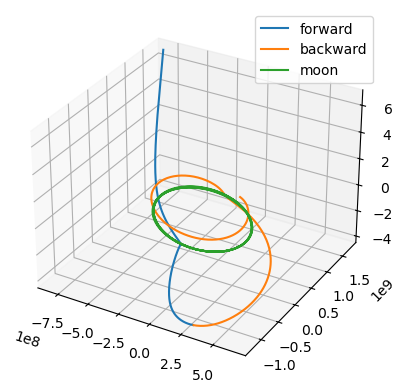

In [18]:
# We first of all need to reconstruct the Earth and Moon position (to plot the difference of the heliocentric spacecraft trajectory w.r.t. the Earth & to plot the Moon trajectory as well)
# Create a dummy time variable, to be able to take the partials of the Earth and Moon positions w.r.t. time, later on:
tm=hk.make_vars("tm")
#useful constants:
AU=149597870.7*1e3#m
day=86400.#s
#we also need the gravitational parameter of Sun, Earth, Moon
mu_sun=hk.model.get_vsop2013_mus()[0]*AU**3/day**2#in m**3/s**2
mu_earth=hk.model.get_elp2000_mus()[0]#in m**3/s**2
mu_moon=hk.model.get_elp2000_mus()[1]#in m**3/s**2

#let's extract the Earth and Moon vecors w.r.t. the Sun (these are essential to compute their gravitational perturbations in the spacecraft dynamics later on)
#ELP returns the Moon-Earth vector:
moon_earth=[]
moon_earth+=hk.model.elp2000_cartesian_fk5(time=(tm/86400.+t0_ref)/36525., thresh=1e-8)
moon_earth=[e*1e3 for e in moon_earth]
#VSOP returns the Earth-Moon barycenter:
earth_moon_barycenter=hk.model.vsop2013_cartesian_icrf(3,time=(tm/86400.+t0_ref)/365250., thresh=1e-8)[:3]
earth_moon_barycenter[:3]=[e*AU for e in earth_moon_barycenter[:3]]
#we compute the Earth-Moon barycenter to Moon, and Earth-Moon barycenter to Earth position vector
b_to_moon=[e*(mu_earth)/(mu_earth+mu_moon) for e in moon_earth]
b_to_earth=[-e*(mu_moon)/(mu_earth+mu_moon) for e in moon_earth]
#we can now build the Moon position vector w.r.t. the Sun:
moon_vector=[a+b for a,b in zip(b_to_moon,earth_moon_barycenter)]
#let's derive the Moon velocity from its position
moon_vector += list(hk.diff_tensors(moon_vector, diff_args=[tm]).jacobian[:,0])
#we do the same with the Earth position vector w.r.t. the Sun:
earth_vector=[a+b for a,b in zip(b_to_earth,earth_moon_barycenter)]
#let's derive the Earth velocity from its position
earth_vector += list(hk.diff_tensors(earth_vector, diff_args=[tm]).jacobian[:,0])
#now we need to substitute the dummy variable with the hkoka time, for this, it is essential
#to do it vectorized, otherwise you have a big slowdown
all_vector=hk.subs(moon_vector+earth_vector,{"tm":hk.time})
moon_vector=all_vector[:6]
earth_vector=all_vector[6:]
#we compule the Earth and Moon position in compact mode, and also extract their values in t0
earth=hk.cfunc(earth_vector,compact_mode=True,vars=[])
moon=hk.cfunc(moon_vector,compact_mode=True,vars=[])

#3D plot of the trajectory
earth_pos=[]
moon_pos=[]
for t_val in t_grid:    
    earth_pos.append(earth(inputs=[],time=t_val))#time_grid.reshape(1,-1))
    moon_pos.append(moon(inputs=[],time=t_val))#time_grid.reshape(1,-1))
earth_pos=np.stack(earth_pos).T
moon_pos=np.stack(moon_pos).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot((out[:,0]-earth_pos[0,:int(n_points/2)]),(out[:,1]-earth_pos[1,:int(n_points/2)]),(out[:,2]-earth_pos[2,:int(n_points/2)]),label='forward')
ax.plot((out_inv[::-1,0][1:]-earth_pos[0,int(n_points/2):]),(out_inv[::-1,1][1:]-earth_pos[1,int(n_points/2):]),(out_inv[::-1,2][1:]-earth_pos[2,int(n_points/2):]),label='backward')
ax.plot((moon_pos[0,:]-earth_pos[0,:]),(moon_pos[1,:]-earth_pos[1,:]),(moon_pos[2,:]-earth_pos[2,:]),label='moon')
ax.legend()


## Surrogate primar vector computation:

In [15]:
p = np.ones((n_points,n_points))
for idx_i in range(n_points):
    if idx_i==n:
            continue
    for idx_j in range(idx_i+1,n_points):
        if idx_j==n:
            continue
        Mif = stms_if[idx_i]
        Mjf = stms_if[idx_j]
        # We now premultiply by Mfn as to simplify the constraint equation
        Mi = Mfn@Mif
        Mj = Mfn@Mjf
        # And compute the Aij
        Mrvj = Mj[:3,3:]
        Mrvi = Mi[:3,3:]
        Mrvi_inv = np.linalg.inv(Mrvi)
        Mvvj = Mj[3:,3:]
        Mvvi = Mi[3:,3:]
        Aij = - Mrvi_inv@Mrvj
        Anj = - (Mvvi@Aij+Mvvj)
        # And B, b
        B = Aij
        b = - DVn@Anj / np.linalg.norm(DVn)
        # and solve
        a,sol = mit.minBu_bu_p(B, b)
        p[idx_i, idx_j] = np.inf
        p[idx_j, idx_i] = a


## Compute the best impulse directions

In [16]:
idx2, idx1 = np.unravel_index(p.argmin(), p.shape)

# We perform the computations again in correspondance of the best point
Mif = stms_if[idx1]
Mjf = stms_if[idx2]
Mi = Mfn@Mif
Mj = Mfn@Mjf
Mrvj = Mj[:3,3:]
Mrvi = Mi[:3,3:]
Mrvi_inv = np.linalg.inv(Mrvi)
Mvvj = Mj[3:,3:]
Mvvi = Mi[3:,3:]
Aij = - Mrvi_inv@Mrvj
Anj = - (Mvvi@Aij+Mvvj)
B = Aij
b = - DVn@Anj / np.linalg.norm(DVn)
a,sol = mit.minBu_bu_p(B, b)

uj = np.array(sol).reshape(3,1)
uj=uj/np.linalg.norm(uj)
dDVn = Anj@uj
dDVi = Aij@uj
ti = t_grid[idx1]
tj = t_grid[idx2]

print("Max of the primer conditions is at: ", ti, tj)
print("Max of the primer value is : ", -np.min(p))

print(f"\nMid course correction at: {tl}, dDVn is {dDVn.flatten()}")
print(f"First added impulse at: {ti}, dDVi is {dDVi.flatten()}")
print(f"Mid course correction at: {tj}, dDVj is {uj.flatten()}")


Max of the primer conditions is at:  7226762.106840836 8812079.905062404
Max of the primer value is :  4.867290005161211

Mid course correction at: 3922155.9922381304, dDVn is [8.95682881 9.81054362 3.10904152]
First added impulse at: 7226762.106840836, dDVi is [-0.94514895 -2.12138048 -0.43584542]
Mid course correction at: 8812079.905062404, dDVj is [-0.93059676 -0.36604154 -0.00180432]


## Plotting the surrogate map

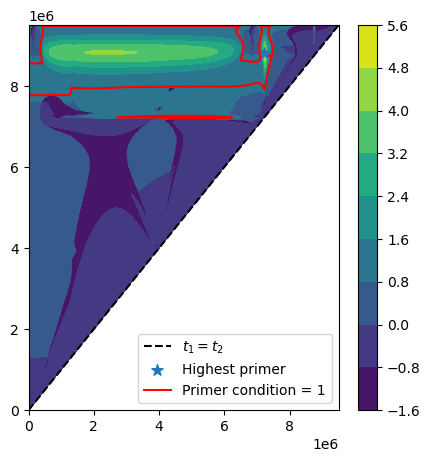

In [17]:
p_clean=p.copy()
# To avoid color saturation to represent areas where the primer condition is way too high
infs = (p_clean>1.) 
p_clean[p_clean > 10] = 1
p_clean[infs] = np.inf
p_clean=-p_clean

fig = plt.figure(figsize=(5,5))
X,Y = np.meshgrid(t_grid, t_grid)
plt.contourf(X,Y,p_clean)
plt.colorbar()
plt.contour(X,Y,p_clean, [1.], colors='r', linestyles='solid')
plt.savefig("surrogate_primer_halo.png", dpi=600)
plt.plot(t_grid,t_grid, 'k--', label="$t_1=t_2$")
plt.scatter(t_grid[idx1], t_grid[idx2], label="Highest primer", marker="*", s=70)
plt.plot([],[], 'r', label="Primer condition = 1")
plt.legend(loc="lower right")

plt.savefig("msr_ero_surrogate_primer_vector.png", dpi=600)